### Relevant Libraries

In [1]:
push!(LOAD_PATH, "../src/")
using GP, PyPlot, Logging
Logging.configure(level=DEBUG, filename="trained_ml.log")

Logger(root,DEBUG,IOStream(<file trained_ml.log>),root)

### Various Analytical Fisher Information

In [2]:
# fisher information at θs due to P evenly spaced training trials
function fisher(θs, P, Δ, σn)
    ker = Kernel(Δ)
    θs_grid = linspace(0, 2π, P+1)[1:end-1]
    Ρ, Σ = val(θs .- θs_grid', ker), cov_uniform(P, ker) + σn^2 * eye(P)
    dΡ = deriv(θs .- θs_grid', ker)
    Σinv = inv(Σ)
    
    rst = diag(dΡ * Σinv * dΡ') ./ diag(1 + σn^2 - Ρ * Σinv * Ρ')
    rst = rst .+ diag(dΡ * Σinv * Ρ').^2 ./ diag(1 + σn^2 - Ρ * Σinv * Ρ').^2
    return vec(rst)
end

# fisher information at θs due a single trial at 0
function fisher_single(θs, Δ, σn)
    ker = Kernel(Δ)
    Ρ, dΡ = val(θs, ker), deriv(θs, ker)
    
    return (dΡ * (1 + σn^2)).^2 ./ ((1 + σn^2)^2 - Ρ.^2).^2
end

# maximum of the single-trial fisher information, exact (information extent)
function fisher_single_max(Δ, σn)
    n = σn^2 * (2 + σn^2) # numerator
    d = σn^2 * (1 + σn^2 / 2) + (1 + σn^2)^2 / sinh(Δ/2)^2 + 1 / (1 - cosh(Δ)) # denominator
    return sqrt(n / d)
end

fisher_single_max (generic function with 1 method)

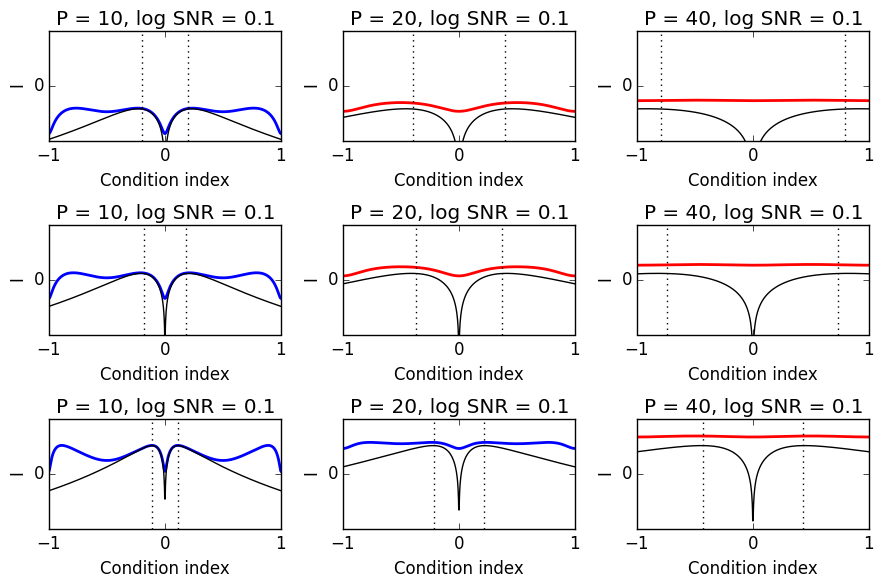

In [3]:
Δ = 1/4
σns, Ps = Float64[sqrt(10), 1, sqrt(0.1)], round(Int64, logspace(log10(10), log10(40), 3))
figure(figsize=(9, 6))
for (ixP, P) in enumerate(Ps)
    θs = linspace(-2π, 2π, 1001) / P
    for (ixσn, σn) in enumerate(σns)
        subplot(3, 3, (ixσn - 1) * 3 + ixP)
        y = fisher(θs, P, Δ, σn)
        if y[251] > y[250]
            plot(θs / (2π / P), log10(fisher(θs, P, Δ, σn)), "r-", linewidth=2)
        else
            plot(θs / (2π / P), log10(fisher(θs, P, Δ, σn)), "b-", linewidth=2)
        end

        plot(θs / (2π / P), log10(fisher_single(θs, Δ, σn)), "k-")
        θmax = fisher_single_max(Δ, σn)
        axvline(θmax / 2π * P, color="k", linestyle=":"); axvline(-θmax / 2π * P, color="k", linestyle=":")
#         axhline(log10(-1/(1 - cosh(1 / Δ)) / σn^2), color="y", linestyle=":")
        ylim([-3, 3])
        PyPlot.locator_params(nbins=3)
        title("P = $P, log SNR = $(0.1)"); ylabel("I"); xlabel("Condition index")
    end
end
tight_layout()

### Simulate Trained Decoder's Performances (averaged over random testing stimuli)

In [4]:
# start the parallel workers
if length(workers()) > 1
    rmprocs(workers())
end
addprocs(11)
@everywhere push!(LOAD_PATH, "../src/")
@everywhere using GP, Optim

In [5]:
# decoder routine, finds location on the manifold with the shortest
function decode(rs_train, θs_train, rs_test, Δ, σn)
    P, M = size(rs_train)
    Ptest, _ = size(rs_test)
    ker = Kernel(Δ)    
    # covariance of training data, which is common
    Σinv = inv_cov_uniform(P, ker; σn=σn)
    # digitization of the decoded stimulus
    θs = linspace(0, 2π, 1025)[1:1024]
    # preallocation the array of ll scores
    scrs = SharedArray(Float64, Ptest, length(θs))
    # compute the scores at all potential 
    @sync @parallel for tmp in [(k, θs[k]) for k in 1:length(θs)]
        ixθ, θ = tmp # index and the candidate stimulus
        p = GP.val(θ - θs_train, ker) # cross-covariance
        μ = vec(p' * Σinv * rs_train) # conditional mean at candidate
        σ2 = 1 + σn^2 - (p' * Σinv * p)[1] # conditional variance
        # compute the penalized score for each of the test response
        scrs[:, ixθ] = Float64[sum((vec(rs_test[ix_test, :]) - μ).^2) / σ2 + log(σ2) * M for ix_test in 1:Ptest]
    end
    # return the minimal nll candidates
    min_ix = round(Int64, mapslices(x -> findmin(x)[2], scrs, 2))
    return θs[min_ix]
end

decode (generic function with 1 method)

In [6]:
# parameters for simulation
Δs, σns = float([0.25, 0.25, 1.0, 1.0]), float([sqrt(2), sqrt(1/2), sqrt(2), sqrt(1/2)])
M, Ps = 500, round(Int64, logspace(log10(4), log10(1000), 10))
Ptest = 20
ntrial = 10

10

In [7]:
errs = SharedArray(Float64, length(Δs), length(Ps), Ptest, ntrial)
errs_theory = SharedArray(Float64, length(Δs), length(Ps), Ptest, ntrial)
for (ix, (Δ, σn)) in enumerate(zip(Δs, σns))
    ker = Kernel(Δ)
    for (ixP, P) in enumerate(Ps)
        debug("ix: $ix, ixP: $ixP")
        for ixtrial in 1:ntrial
            # training and testing stimulus
            θs_train = linspace(0, 2π, P+1)[1:P]
            θs_test = rand(Ptest) * 2π
            # generate the noisy responses of training and testing together
            tmp = GP.tc2([θs_train; θs_test], M, ker; σn=σn)
            rs_train, rs_test = tmp[1:P, :], tmp[P+1:end, :]
            # decode and compute the simulated error
            θs_hat = decode(rs_train, θs_train, rs_test, Δ, σn)
            errs[ix, ixP, :, ixtrial] = imag(log(exp(1im * (θs_test - θs_hat))))
            # theoretically predicted error based on fisher information
            J = fisher(θs_test, P, Δ, σn)
            errs_theory[ix, ixP, :, ixtrial] = 1 ./ J
        end
    end
end

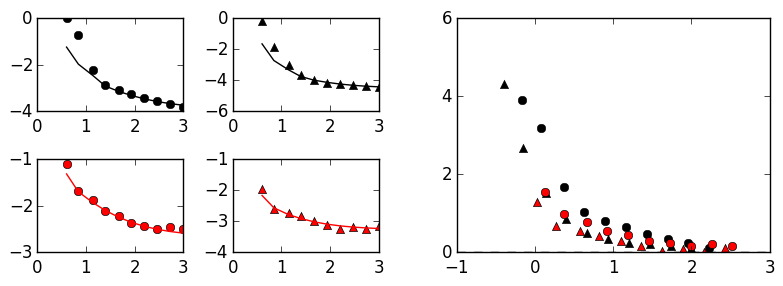

In [8]:
figure(figsize=(8, 3))

symbols = ["o", "^", "o", "^"]
colors = ["k", "k", "r", "r"]
for (ix, (Δ, σn)) in enumerate(zip(Δs, σns))
    snr = 1/σn^2
    hw = sqrt((2 + 1/snr) / snr / (1 / snr * (1 + 2 / snr) + (1 + 1/snr)^2/sinh(Δ/2) + 1 / (cosh(Δ) - 1)))
    hw = pi / 2 / hw
    if ix > 2
        fix = ix + 2
    else 
        fix = ix
    end
    subplot(2, 4, fix)
    PyPlot.locator_params(nbins=3)
    plot(log10(Ps),
         log10(vec(mean(mean(errs[ix, :, :, :].^2, 3), 4))),
         symbols[ix], color=colors[ix])
    plot(log10(Ps),
         log10(vec(mean(mean(errs_theory[ix, :, :, :], 3), 4))/M),
         "-", color=colors[ix])
#     ylim([-6, 0])
    
    subplot(122)
    PyPlot.locator_params(nbins=4)
    plot(log10(Ps / hw),
         log10(vec(mean(mean(errs[ix, :, :, :].^2, 3), 4)) * (M / σn^2 / (cosh(Δ) - 1))),
         symbols[ix], color=colors[ix])
#     ylim([-1, 5])
#     xlim([-1, 2])
end
PyPlot.axhline(0, color="k", linestyle="--")
tight_layout()
savefig("trained_ml_sim.eps")

### Test decoding performance as a function of the test stimulus (depending on how far froming training data)

In [9]:
# simulation parameters
Δ = 0.25
ker = Kernel(Δ)
σn = sqrt(0.5)
P, M, Ptest, ntrial = 20, 500, 21, 1000

(20,500,21,1000)

In [10]:
# running the simulation
errs = zeros(Ptest, ntrial)
for ixtrial in 1:ntrial
    θs_train = linspace(0, 2π, P+1)[1:P] # training trials
    θs_test = linspace(0, 4π / P, Ptest) + 2π / P * 10 # non-random test stimuli between training stimuli
    # generate noisy responoses
    tmp = GP.tc2([θs_train; θs_test], M, ker; σn=σn)
    rs_train, rs_test = tmp[1:P, :], tmp[(P+1):end, :]
    # decode
    θs_hat = decode(rs_train, θs_train, rs_test, Δ, σn)
    errs[:, ixtrial] = imag(log(exp(1im * (θs_test - θs_hat))))
end

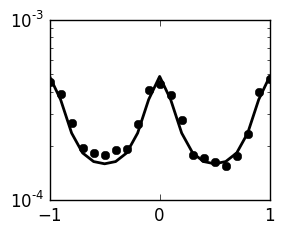

In [11]:
# plot the results between three different training trials
figure(figsize=(3, 2.5))
PyPlot.locator_params(nbins=3)
θs = linspace(-2π/P, 2π/P, Ptest)
y = fisher(θs, P, Δ, σn)
plot(θs / (2π / P), 1 ./ fisher(θs, P, Δ, σn) / M, "k-", linewidth=2)
plot(θs / (2π / P), vec(mean(errs.^2, 2)), "ko")
yscale("log")
tight_layout()

### Decoding performance in the P vs SNR plane

In [12]:
# parameters
Δ = 0.25
σns = logspace(1/2, -1, 40)
M, Ps = 500, round(Int64, logspace(log10(2), log10(200), 40))
Ptest = 500

500

In [ ]:
# run simulations
errs = zeros(length(σns), length(Ps), Ptest)
for (ixσn, σn) in enumerate(σns)
    ker = Kernel(Δ)
    for (ixP, P) in enumerate(Ps)
        θs_train = linspace(0, 2π, P+1)[1:P]
        θs_test = rand(Ptest) * 2π
        tmp = GP.tc2([θs_train; θs_test], M, ker; σn=σn)
        rs_train, rs_test = tmp[1:P, :], tmp[P+1:end, :]
        debug("ixσn: $ixσn, ixP: $ixP")
        
        θs_hat = decode(rs_train, θs_train, rs_test, Δ, σn)
        errs[ixσn, ixP, :] = imag(log(exp(1im * (θs_test - θs_hat))))
    end
end

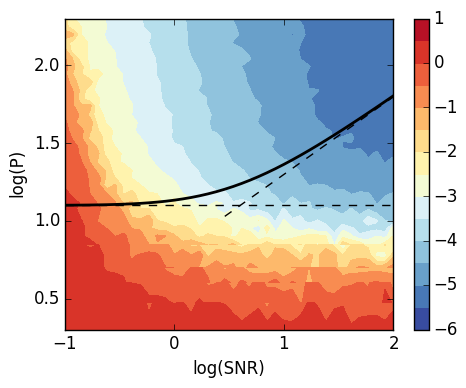

In [16]:
figure(figsize=(5, 4))
PyPlot.locator_params(nbins=5)
# specify the levels of the contours
levels = linspace(-6, 1, 15)
# plot the conoutrs
a = contourf(-2 * log10(σns), log10(Ps), log10(squeeze(mean(errs.^2, 3), 3))', 10, cmap="RdYlBu_r", levels=levels)
colorbar()
# plot the theoretically computed sufficient number of trials
plot(log10(1 ./ σns.^2), log10(π / 2 ./ Float64[fisher_single_max(Δ, x) for x in σns]), "k", linewidth=2)
# in the low SNR limit
PyPlot.axhline(log10(π / Δ), color="k", linestyle="--")
# in the high SNR limit
plot(log10(1 ./ σns.^2)[Int64(end/2):end], log10(π / Δ * 0.5 ./ σns)[Int64(end/2):end], color="k", linestyle="--")
xlabel("log(SNR)"); ylabel("log(P)")
tight_layout()